In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [3]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

c:\Users\nolan\anaconda3\envs\sp25_taxi\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-02-22 16:40:09,759 INFO: Initializing external client
2025-02-22 16:40:09,759 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-02-22 16:40:11,388 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1212635


In [4]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1212635/fs/1200268/fv/time_series_hourly_feature_view/version/1
Feature view 'time_series_hourly_feature_view' (version 1) created successfully.
Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [5]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (14.32s) 


In [6]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [7]:
ts_data.shape

(4882176, 3)

In [8]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4882176 entries, 0 to 4882175
Data columns (total 3 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   pickup_hour         object
 1   pickup_location_id  int32 
 2   rides               int32 
dtypes: int32(2), object(1)
memory usage: 74.5+ MB


In [9]:
ts_data.describe()

,pickup_location_id,rides
count,4.882176e+06,4.882176e+06
mean,1.327842e+02,1.697455e+01
std,7.586718e+01,5.226783e+01
min,2.000000e+00,0.000000e+00
25%,6.700000e+01,0.000000e+00
50%,1.340000e+02,0.000000e+00
75%,1.990000e+02,2.000000e+00
max,2.630000e+02,1.089000e+03


In [10]:
ts_data['pickup_hour'].min()

'2023-01-01 00:00:00+00:00'

In [11]:
ts_data['pickup_hour'].max()

'2025-02-22 15:00:00+00:00'

In [12]:
ts_data_copy = ts_data.copy()

In [13]:
ts_data.tail()

,pickup_hour,pickup_location_id,rides
4882171,2025-02-22 11:00:00+00:00,263,130
4882172,2025-02-22 12:00:00+00:00,263,152
4882173,2025-02-22 13:00:00+00:00,263,143
4882174,2025-02-22 14:00:00+00:00,263,111
4882175,2025-02-22 15:00:00+00:00,263,141


In [14]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [15]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [16]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4882176 entries, 0 to 4882175
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 74.5 MB


In [18]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

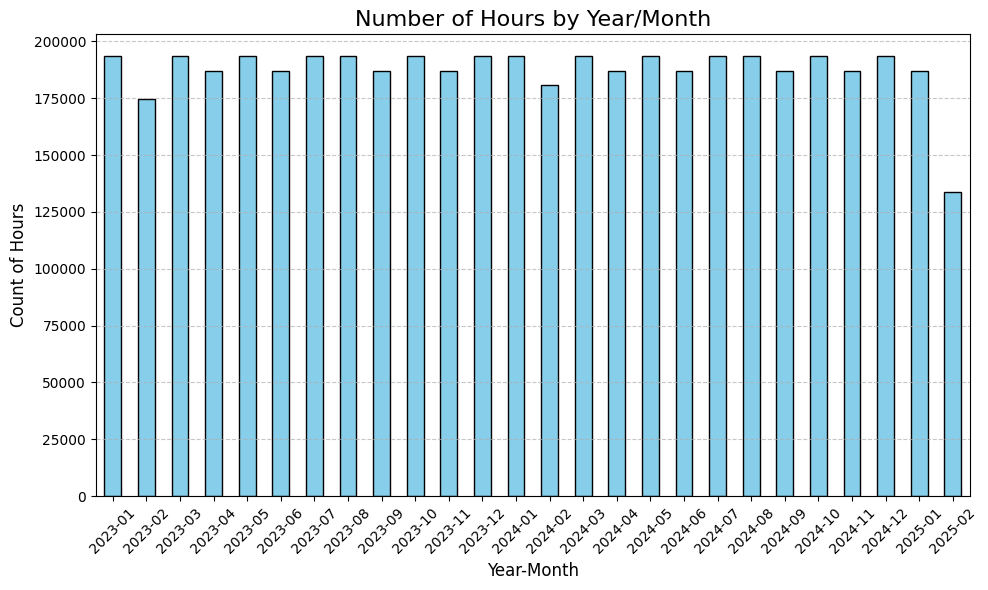

In [19]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [20]:
ts_data.head()

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01


In [21]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

In [22]:
features.rename(columns={'location_id':'pickup_location_id'}, inplace=True)

In [23]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204713,7,4,2,8,14,48,124,138,130,122,...,82,102,84,71,52,43,18,10,2025-02-18 01:00:00,263
204714,17,19,6,3,4,13,42,127,127,132,...,90,99,90,106,77,56,57,25,2025-02-19 00:00:00,263
204715,43,17,15,3,3,8,18,50,127,149,...,107,100,102,129,101,110,107,72,2025-02-19 23:00:00,263
204716,81,65,35,16,19,7,15,18,59,124,...,94,110,137,112,122,126,119,113,2025-02-20 22:00:00,263


In [24]:
features_copy = features.copy()

In [25]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(204718, 675)

In [26]:
features_targets.head()

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id,target
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2023-01-29 00:00:00,2,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2023-01-29 23:00:00,2,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2023-01-30 22:00:00,2,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2023-01-31 21:00:00,2,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2023-02-01 20:00:00,2,0


In [27]:
from datetime import datetime, timedelta
import pandas as pd
from src.data_utils import split_time_series_data

# Define the cutoff date as 28 days before today
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=180))
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2024-08-26 16:44:08.712022')

In [28]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(156260, 674)
(156260,)
(48458, 674)
(48458,)


In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156260 entries, 0 to 156259
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(672)
memory usage: 802.9 MB


In [30]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [31]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.805352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171646
[LightGBM] [Info] Number of data points in the train set: 204718, number of used features: 675
[LightGBM] [Info] Start training from score 16.963731


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x000001D7AB5111C0>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [32]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [33]:
predictions

array([  0.18627644,   0.18627644,   0.18627644, ...,  39.65630117,
        91.83342546, 105.35038205])

In [34]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

2.3846


In [35]:
import joblib


# Save the pipeline
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['C:\\Users\\nolan\\cda500\\sp25_taxi\\models\\lgb_model.pkl']

In [36]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [37]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003

In [38]:
model.save('C:\\Users\\nolan\\cda500\\sp25_taxi\\models\\lgb_model.pkl')

Uploading: 100.000%|██████████| 318935/318935 elapsed<00:02 remaining<00:00  1.11it/s]
Uploading: 100.000%|██████████| 2049/2049 elapsed<00:01 remaining<00:000:08,  2.01s/it]
Uploading: 100.000%|██████████| 51418/51418 elapsed<00:02 remaining<00:00
Model export complete: 100%|██████████| 6/6 [00:13<00:00,  2.29s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/1212635/models/taxi_demand_predictor_next_hour/2


Model(name: 'taxi_demand_predictor_next_hour', version: 2)

In [39]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-02-22 16:45:27,690 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-02-22 16:45:27,753 INFO: Initializing external client
2025-02-22 16:45:27,755 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-02-22 16:45:28,774 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1212635


In [40]:
from src.inference import get_model_predictions

preds = get_model_predictions(model, features_copy)

In [41]:
preds

,pickup_location_id,predicted_demand
0,2,0.0
1,2,0.0
2,2,0.0
3,2,0.0
4,2,0.0
...,...,...
204713,263,8.0
204714,263,17.0
204715,263,40.0
204716,263,92.0


In [42]:
test_mae = mean_absolute_error(targets, preds['predicted_demand'])
print(f"{test_mae:.4f}")

2.2862
